### Short Ratio Data:
This data, which shows the ratio of shorted shares to the average daily volume, can be a key indicator of market sentiment towards a stock. A high short ratio may suggest that a significant portion of the market is betting against the stock, setting the stage for a potential short squeeze if the stock price begins to rise.

In [2]:
from yahoo_fin import stock_info as finance
import pandas as pd

In [6]:
# Short sale volume

class ShortSaleVolume:
    
    bucket = 'mads-capstone-2023' 
    data_key = 'FINRA_Short_Sale_Data.csv' 
    data_location = 's3://{}/{}'.format(bucket, data_key) 
    
    def __init__(self):
        self.has_downloaded = False 
    
    # Function to download data from S3
    def get_data(self):
        if not self.has_downloaded:
            self.df = pd.read_csv(self.data_location)
            self.df.drop(['Unnamed: 0'], axis = 1, inplace = True)
            self.df['shortvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['short_ratio'] = 1 - self.df['short_ratio']
            self.has_downloaded = True
        else:
            pass
        
    def short_ratio(self, ticker):
        # Check if data has been downloaded locally
        self.get_data()
        
        # Return data for ticker 
        df_ = self.df[self.df['ticker'] == ticker].copy()
        df_['date'] = pd.to_datetime(df_['date'])
        df_.set_index('date', inplace=True)
        return df_

    
    def calculate_short_ratio_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]
        for period in periods:
            df[f'short_ratio_mean_{period}'] = df['short_ratio'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_ratio_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_ratio_mean_{periods[i]}'] / df[f'short_ratio_mean_{periods[j]}']
                    df[f'short_ratio_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_ratio_mean_{periods[j]}'] / df[f'short_ratio_mean_{periods[i]}']

        if include_roc:
            # print('working')
            for col in df.columns:
                if 'short_ratio_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_ratio_mean_' in col or ('roc' in col and 'short_ratio_mean_' in col)]]
        return result_df

    def calculate_short_exempt_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]

        df['short_exempt_percent'] = (df['shortexemptvolume'] / df['totalvolume'])

        for period in periods:
            df[f'short_exempt_percent_mean_{period}'] = df['short_exempt_percent'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_exempt_percent_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_exempt_percent_mean_{periods[i]}'] / df[f'short_exempt_percent_mean_{periods[j]}']
                    df[f'short_exempt_percent_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_exempt_percent_mean_{periods[j]}'] / df[f'short_exempt_percent_mean_{periods[i]}']

        if include_roc:
            for col in df.columns:
                if 'short_exempt_percent_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_exempt_percent_mean_' in col or ('roc' in col and 'short_exempt_percent_mean_' in col)]]
        return result_df

# Example usage 
analysis = ShortSaleVolume()
# df_gme_short_ratio = analysis.calculate_short_ratio_means('GME', include_roc = False)
# df_gme_short_sale_exempt = analysis.calculate_short_exempt_means('GME', include_roc = False)


In [70]:
def get_data(ticker = 'GME', sdate = '20160101', edate = '20231115'):
    # Pull data for an individual ticker 
    df_ohlcv = finance.get_data(ticker, sdate, edate)[['ticker', 'close', 'volume']].rename({'close':'Close', 'volume':'Volume', 'ticker':'Ticker'}, axis = 1)
    df_sr = analysis.calculate_short_ratio_means(ticker, include_roc = False).rename({'short_ratio_mean_1': 'ShortRatio'}, axis = 1)['ShortRatio']
    df = df_ohlcv.join(df_sr).dropna()
    df = df[~df.index.duplicated(keep='first')]
    return df

In [141]:
import pandas as pd

def identify_potential_short_squeezes(merged_data, price_jump_threshold, high_short_ratio_threshold, lag_days):
    """
    Identify stocks with a high short ratio followed by a significant price increase over trading days.

    :param merged_data: DataFrame with columns ['Ticker', 'Date', 'Close', 'Volume', 'ShortRatio']
    :param price_jump_threshold: Percentage increase in price to consider (e.g., 0.20 for 20%)
    :param high_short_ratio_threshold: Short ratio value to consider as 'high' (e.g., 5)
    :param lag_days: Number of trading days to look ahead for a price jump after a high short ratio
    :return: DataFrame with potential short squeezes
    """
    
    # Ensure 'Date' is in datetime format
    merged_data['Date'] = pd.to_datetime(merged_data.index)

    # Calculate the daily price change percentage
    merged_data['PriceChange'] = merged_data.groupby('Ticker')['Close'].pct_change()

    # Prepare a list to store potential squeezes rows
    potential_squeeze_rows = []

    # Iterate through each row in the merged data
    for index, row in merged_data.iterrows():
        if row['ShortRatio'] >= high_short_ratio_threshold:
            # Get the index for the current row
            current_index = merged_data.index.get_loc(row.name)

            # Determine the end index for the lag period (considering trading days)
            end_index = min(current_index + lag_days, len(merged_data) - 1)

            # Filter for dates within the lag period (trading days)
            lag_period_data = merged_data.iloc[current_index + 1:end_index + 1].copy()
            lag_period_data['trigger_date'] = row['Date']
            lag_period_data['trigger_date_close'] = row['Close']
            lag_period_data['trigger_date_short_ratio'] = row['ShortRatio']

            # Check for significant price jumps within the lag period
            for lag_index, lag_row in lag_period_data.iterrows():
                if lag_row['PriceChange'] >= price_jump_threshold:
                    # Calculate the number of trading days between trigger date and this row's date
                    trading_days_diff = merged_data.index.get_loc(lag_index) - current_index
                    lag_row['TradingDaysDiff'] = trading_days_diff
                    potential_squeeze_rows.append(lag_row)

    # Check if the list is empty
    if not potential_squeeze_rows:
        return pd.DataFrame()  # Return an empty DataFrame if no squeezes are found
    else:
        # Concatenate all rows into a DataFrame
        potential_squeezes = pd.concat(potential_squeeze_rows, axis=1).transpose()
        return potential_squeezes.drop_duplicates()


# Example usage
price_jump_threshold = 0.20  # 20%
high_short_ratio_threshold = 0.65
lag_days = 5  # Look ahead for 5 days
# Assuming 'merged_data' is already loaded and prepared
potential_squeezes = identify_potential_short_squeezes(merged_data, price_jump_threshold, high_short_ratio_threshold, lag_days)
pd.DataFrame(potential_squeezes)


,Ticker,Close,Volume,ShortRatio,Date,PriceChange,trigger_date,trigger_date_close,trigger_date_short_ratio,TradingDaysDiff
2020-04-27,GME,1.455,29100400,0.432033,2020-04-27,0.220126,2020-04-20,1.4025,0.663556,5
2020-08-31,GME,1.67,151904000,0.71329,2020-08-31,0.239332,2020-08-24,1.2175,0.706712,5
2020-08-31,GME,1.67,151904000,0.71329,2020-08-31,0.239332,2020-08-28,1.3475,0.664816,1
2020-09-16,GME,2.17,77025200,0.441774,2020-09-16,0.22426,2020-09-11,1.5225,0.726376,3
2021-01-13,GME,7.85,578006800,0.467823,2021-01-13,0.573935,2021-01-06,4.59,0.706708,5
2021-01-22,GME,16.252501,788631600,0.657569,2021-01-22,0.510807,2021-01-14,9.9775,0.683725,5
2021-01-22,GME,16.252501,788631600,0.657569,2021-01-22,0.510807,2021-01-15,8.875,0.677417,4
2021-01-22,GME,16.252501,788631600,0.657569,2021-01-22,0.510807,2021-01-19,9.84,0.670158,3
2021-01-26,GME,36.994999,714352000,0.669118,2021-01-26,0.927074,2021-01-19,9.84,0.670158,5
2021-01-22,GME,16.252501,788631600,0.657569,2021-01-22,0.510807,2021-01-20,9.78,0.65454,2


In [43]:
def identify_potential_short_squeezes(merged_data, z_score_threshold, high_short_ratio_threshold, lookback_period=90, lag_days_start=2, lag_days_end=5):
    """
    Identify stocks with a high short ratio followed by a significant price increase 
    based on rolling Z-scores over a prior lookback period.

    :param merged_data: DataFrame with columns ['Ticker', 'Date', 'Close', 'Volume', 'ShortRatio']
    :param z_score_threshold: Z-score threshold for significant price move (e.g., 1, 1.5, 2)
    :param high_short_ratio_threshold: Short ratio value to consider as 'high'
    :param lookback_period: Lookback period for calculating Z-scores (e.g., 90 days)
    :param lag_days_start: Start of the range for the lag days (e.g., 2)
    :param lag_days_end: End of the range for the lag days (e.g., 5)
    :return: DataFrame with potential short squeezes
    """
    
    # Ensure 'Date' is in datetime format
    merged_data['Date'] = pd.to_datetime(merged_data.index)

    # Calculate the daily price change percentage
    merged_data['PriceChange'] = merged_data.groupby('Ticker')['Close'].pct_change()

    # Calculate rolling mean and std of price changes
    merged_data['PriceChangeMean'] = merged_data.groupby('Ticker')['PriceChange'].rolling(window=lookback_period).mean().reset_index(level=0, drop=True)
    merged_data['PriceChangeStd'] = merged_data.groupby('Ticker')['PriceChange'].rolling(window=lookback_period).std().reset_index(level=0, drop=True)

    # Calculate Z-scores
    merged_data['PriceChangeZScore'] = (merged_data['PriceChange'] - merged_data['PriceChangeMean']) / merged_data['PriceChangeStd']

    # Prepare a list to store potential squeezes rows
    potential_squeeze_rows = []

    # Iterate through each row in the merged data
    for index, row in merged_data.iterrows():
        if row['ShortRatio'] >= high_short_ratio_threshold:
            current_index = merged_data.index.get_loc(row.name)
            start_index = min(current_index + lag_days_start, len(merged_data) - 1)
            end_index = min(current_index + lag_days_end, len(merged_data) - 1)

            # Filter for dates within the lag period
            lag_period_data = merged_data.iloc[start_index:end_index + 1].copy()
            lag_period_data['trigger_date'] = row['Date']
            lag_period_data['trigger_date_close'] = row['Close']
            lag_period_data['trigger_date_short_ratio'] = row['ShortRatio']

            # Check for significant price jumps within the lag period
            for lag_index, lag_row in lag_period_data.iterrows():
                if (lag_row['PriceChangeZScore']) >= z_score_threshold:
                    trading_days_diff = merged_data.index.get_loc(lag_index) - current_index
                    lag_row['TradingDaysDiff'] = trading_days_diff
                    potential_squeeze_rows.append(lag_row)
                    

    if not potential_squeeze_rows:
        return pd.DataFrame()
    else:
        return pd.concat(potential_squeeze_rows, axis=1).transpose().drop_duplicates()

# Example usage
z_score_threshold = 1.5  # For example, 1.5 Z-score
high_short_ratio_threshold = 0.65
# Assuming 'merged_data' is already loaded and prepared
merged_data = get_data()
potential_squeezes = identify_potential_short_squeezes(merged_data, z_score_threshold, high_short_ratio_threshold)
pd.DataFrame(potential_squeezes)


,Ticker,Close,Volume,ShortRatio,Date,PriceChange,PriceChangeMean,PriceChangeStd,PriceChangeZScore,trigger_date,trigger_date_close,trigger_date_short_ratio,TradingDaysDiff
2020-03-02,GME,0.9575,12833600,0.541718,2020-03-02,0.063889,-0.003944,0.042259,1.60517,2020-02-25,0.89,0.673733,4
2020-03-19,GME,1.0475,20158000,0.342363,2020-03-19,0.111406,-0.003143,0.050027,2.289734,2020-03-17,1.0575,0.852986,2
2020-03-24,GME,1.04,27222400,0.474178,2020-03-24,0.091863,-0.002571,0.052074,1.813465,2020-03-17,1.0575,0.852986,5
2020-03-24,GME,1.04,27222400,0.474178,2020-03-24,0.091863,-0.002571,0.052074,1.813465,2020-03-18,0.9425,0.767712,4
2020-04-27,GME,1.455,29100400,0.432033,2020-04-27,0.220126,0.003323,0.075274,2.880179,2020-04-20,1.4025,0.663556,5
2020-08-31,GME,1.67,151904000,0.71329,2020-08-31,0.239332,0.00556,0.059145,3.952532,2020-08-24,1.2175,0.706712,5
2020-09-01,GME,1.9125,92634400,0.798056,2020-09-01,0.14521,0.007008,0.060944,2.267692,2020-08-28,1.3475,0.664816,2
2020-09-14,GME,1.7275,40476000,0.387756,2020-09-14,0.134647,0.00537,0.058103,2.224962,2020-09-04,1.9125,0.680661,5
2020-09-16,GME,2.17,77025200,0.441774,2020-09-16,0.22426,0.008035,0.062491,3.460079,2020-09-11,1.5225,0.726376,3
2021-01-13,GME,7.85,578006800,0.467823,2021-01-13,0.573935,0.020189,0.104111,5.318785,2021-01-06,4.59,0.706708,5


In [45]:
def return_etf_holdings(ticker = 'SPY'):

    headers = requests.utils.default_headers()
    headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
    res = requests.get("https://www.zacks.com/funds/etf/%s/holding"%ticker,  headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    js = None
    for script in soup.find_all("script"):
        if "etf_holdings.formatted_data = " in str(script):
    #    if "etf_holdings" in str(script):
            js = str(script)
    holdings = []
    # for line in js.text.split("["):
    for line in js.split("["):
        if "rel=" in line:
            line_soup = BeautifulSoup(line, 'html.parser')
            #holding = line_soup.find("a")["alt"].strip('\\"')
            holding = line_soup.find('a')['rel'][0].strip('\\"')
            holdings.append(holding)

    return holdings

In [109]:
import random
import requests
from bs4 import BeautifulSoup

tickers = return_etf_holdings('SPY')
tickers = random.sample(tickers, k = 50)
tickers.append('GME')
tickers = list(set(tickers))
tickers[:5]

['ETR', 'ABBV', 'CNC', 'ACGL', 'NDAQ']

In [110]:
# What's a typically 2 standard deviation value of short_ratio?
df_spy = get_data('SPY')
df_spy['ShortRatio'].std() * 2 + df_spy['ShortRatio'].mean()

0.6385050081429179

In [111]:
from tqdm import tqdm

# Example usage
z_score_threshold = 2  # For example, 1.5 Z-score
high_short_ratio_threshold = df_spy['ShortRatio'].std() * 2 + df_spy['ShortRatio'].mean() # 2 std move of SPY 

df_repo = []

for ticker in tqdm(tickers):

    try:
        # Get data 
        df_data = get_data(ticker).dropna()

        # Calc results
        potential_squeezes = identify_potential_short_squeezes(df_data, z_score_threshold, high_short_ratio_threshold)

        # Append and continue
        df_repo.append(potential_squeezes)
    except:
        continue
    


100%|██████████| 51/51 [01:10<00:00,  1.37s/it]


In [112]:
df_res = pd.concat(df_repo)

In [113]:
def clean_and_format_output(df):
    """
    Clean and format the output DataFrame for easier interpretation.

    :param df: DataFrame with the output of identify_potential_short_squeezes()
    :return: Cleaned and formatted DataFrame
    """
    # Creating a copy of the DataFrame to avoid SettingWithCopyWarning
    df_clean = df.copy()

    # Renaming columns for clarity
    df_clean.rename(columns={
        'Date': 'PriceJumpDate',
        'trigger_date': 'TriggerDate',
        'trigger_date_close': 'TriggerDateClose',
        'trigger_date_short_ratio': 'TriggerDateShortRatio',
        'TradingDaysDiff': 'DaysAfterTrigger',
        'PriceChangeZScore': 'PriceJumpZScore'
    }, inplace=True)

    # Selecting relevant columns
    relevant_columns = [
        'Ticker', 'TriggerDate', 'TriggerDateClose', 'TriggerDateShortRatio', 
        'PriceJumpDate', 'Close', 'PriceJumpZScore', 'DaysAfterTrigger'
    ]
    df_clean = df_clean[relevant_columns]

    # Formatting dates and rounding numbers, handling NaN values
    df_clean['TriggerDate'] = df_clean['TriggerDate'].dt.strftime('%Y-%m-%d')
    df_clean['PriceJumpDate'] = df_clean['PriceJumpDate'].dt.strftime('%Y-%m-%d')
    df_clean['TriggerDateClose'] = pd.to_numeric(df_clean['TriggerDateClose']).round(2).fillna('N/A')
    df_clean['Close'] = pd.to_numeric(df_clean['Close']).round(2).fillna('N/A')
    df_clean['PriceJumpZScore'] = pd.to_numeric(df_clean['PriceJumpZScore']).round(2).fillna('N/A')

    # Adding descriptive columns
    df_clean['SignificantPriceJump'] = df_clean['PriceJumpZScore'] >= z_score_threshold

    return df_clean



In [114]:
df_final = clean_and_format_output(df_res)

In [171]:
df_final.to_csv('Positive cases.csv', index = False)

Ticker: The stock symbol.

TriggerDate: The date when a high short ratio was detected. A high short ratio indicates a large number of shorted shares relative to the total shares available, suggesting that many investors are betting that the stock's price will fall.

TriggerDateClose: The closing price of the stock on the TriggerDate.

TriggerDateShortRatio: The short ratio on the TriggerDate. A higher ratio suggests more short interest.

PriceJumpDate: The date when a significant price increase occurred. This is within 2-5 days after the TriggerDate, as specified in your function.

Close: The closing price of the stock on the PriceJumpDate.

PriceJumpZScore: The Z-score of the price change on the PriceJumpDate. This score measures how many standard deviations the price change is from the average price change over a lookback period. A higher Z-score indicates a more significant price change.

DaysAfterTrigger: The number of trading days between the TriggerDate and the PriceJumpDate.

SignificantPriceJump: A boolean indicating whether the price jump was significant based on the Z-score threshold you set. True means the price jump was significant.

Example Interpretation of a Row:
For the first row:
- Ticker: VMC
- TriggerDate: 2018-12-19
- TriggerDateClose: 95.93
- TriggerDateShortRatio: 0.656441
- PriceJumpDate: 2018-12-26
- Close on PriceJumpDate: $96.72
- PriceJumpZScore: 2.37
- DaysAfterTrigger: 4
- SignificantPriceJump: True
- This row indicates that for the stock VMC, a high short ratio was detected on December 19, 2018, when the closing price was 95.93. Then, four trading days later, on December 26, 2018, the stock's closing price increased to 96.72, which was a significant price increase (as the Z-score of 2.37 is above your threshold, and SignificantPriceJump is True).


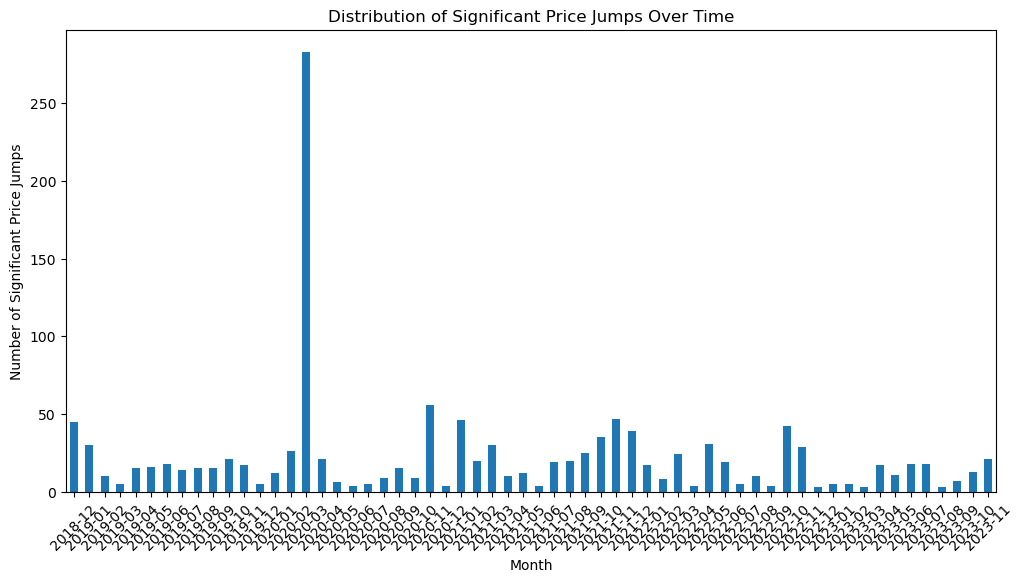

In [118]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'PriceJumpDate' is a datetime for plotting
df_final['PriceJumpDate'] = pd.to_datetime(df_final['PriceJumpDate'])

# Plotting
plt.figure(figsize=(12, 6))
df_final['PriceJumpDate'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Significant Price Jumps Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Significant Price Jumps')
plt.xticks(rotation=45)
plt.show()


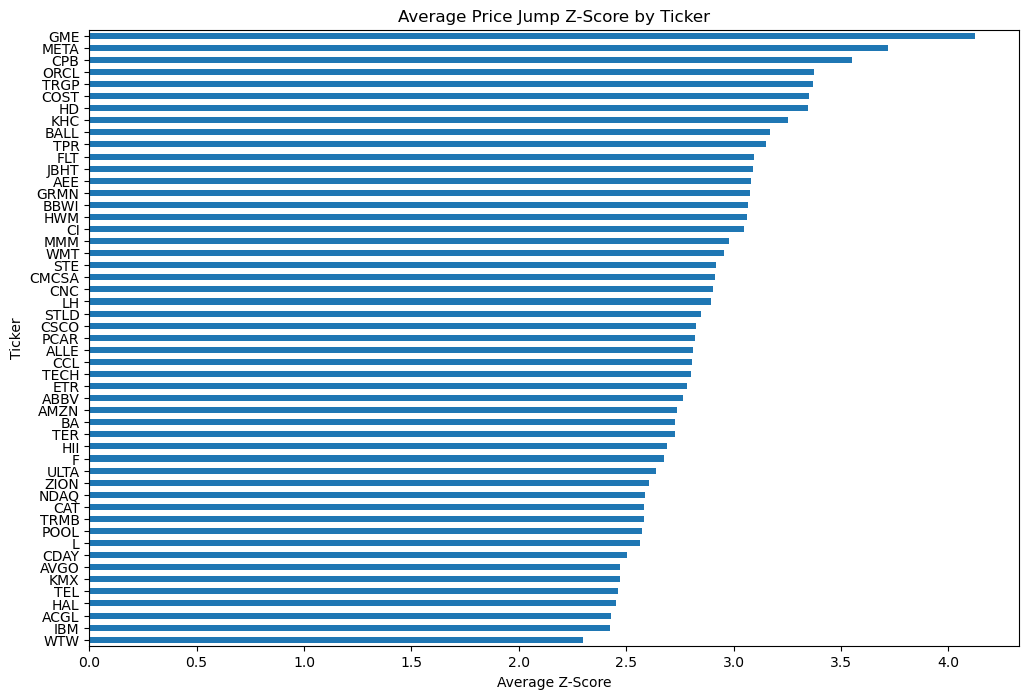

In [121]:
plt.figure(figsize=(12, 8))
df_final.groupby('Ticker')['PriceJumpZScore'].mean().sort_values().plot(kind='barh')
plt.title('Average Price Jump Z-Score by Ticker')
plt.xlabel('Average Z-Score')
plt.ylabel('Ticker')
plt.show()


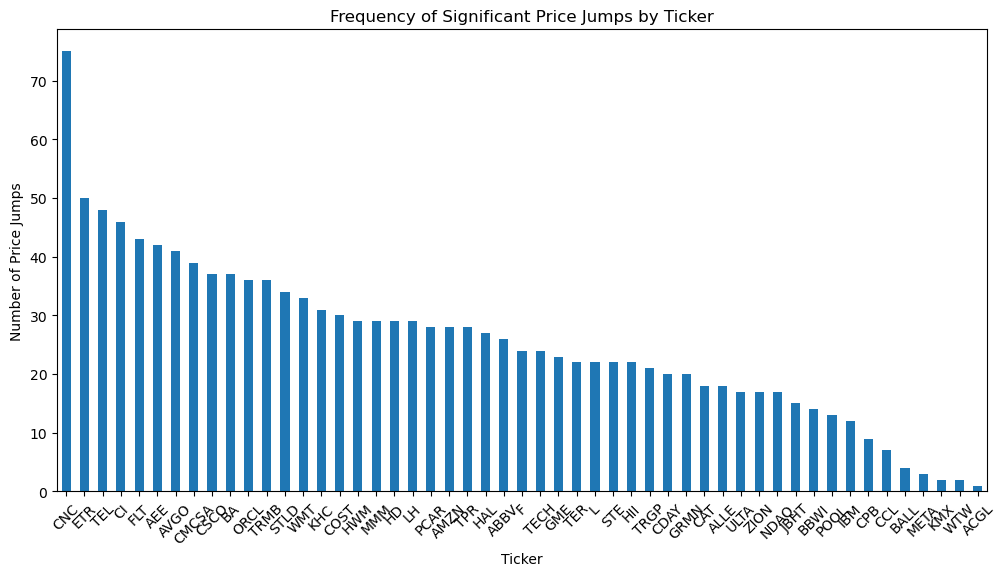

In [122]:
plt.figure(figsize=(12, 6))
df_final['Ticker'].value_counts().plot(kind='bar')
plt.title('Frequency of Significant Price Jumps by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Number of Price Jumps')
plt.xticks(rotation=45)
plt.show()


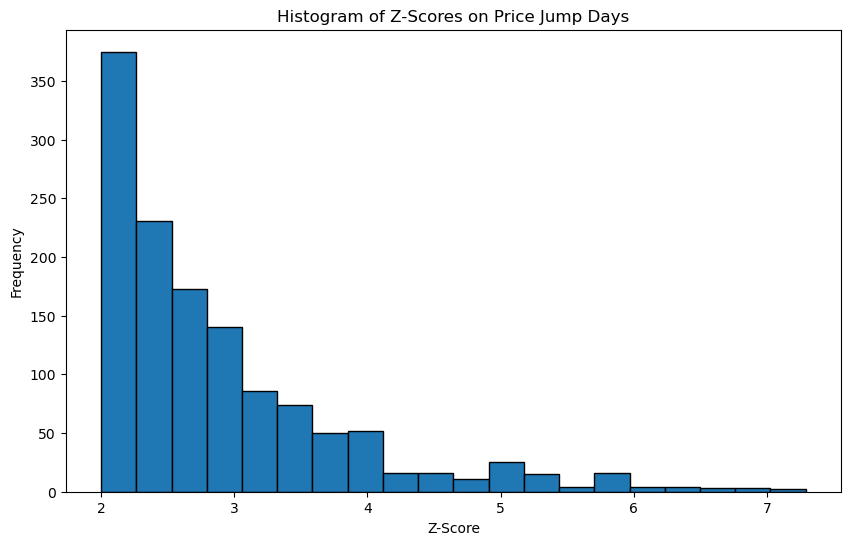

In [125]:
plt.figure(figsize=(10, 6))
df_final['PriceJumpZScore'].hist(bins=20, edgecolor='black')
plt.title('Histogram of Z-Scores on Price Jump Days')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


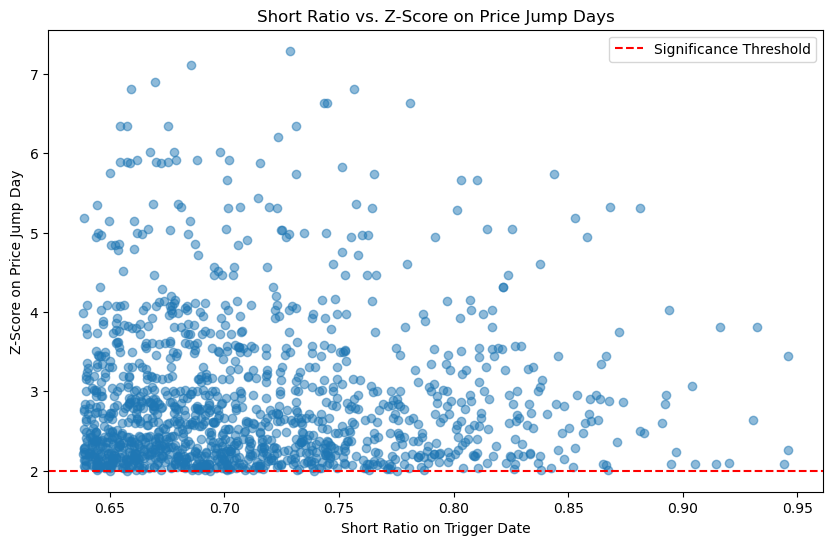

In [126]:
plt.figure(figsize=(10, 6))
plt.scatter(df_final['TriggerDateShortRatio'], df_final['PriceJumpZScore'], alpha=0.5)
plt.title('Short Ratio vs. Z-Score on Price Jump Days')
plt.xlabel('Short Ratio on Trigger Date')
plt.ylabel('Z-Score on Price Jump Day')
plt.axhline(y=z_score_threshold, color='r', linestyle='--', label='Significance Threshold')
plt.legend()
plt.show()


In [168]:
def identify_potential_short_squeezes(merged_data, z_score_threshold, high_short_ratio_threshold, lookback_period=90, lag_days_start=2, lag_days_end=5,
                                     include_negative_squeeze_rows = True, negative_lower_bound = -1, negative_upper_bound = 1):
    """
    Identify stocks with a high short ratio followed by a significant price increase 
    based on rolling Z-scores over a prior lookback period.

    :param merged_data: DataFrame with columns ['Ticker', 'Date', 'Close', 'Volume', 'ShortRatio']
    :param z_score_threshold: Z-score threshold for significant price move (e.g., 1, 1.5, 2)
    :param high_short_ratio_threshold: Short ratio value to consider as 'high'
    :param lookback_period: Lookback period for calculating Z-scores (e.g., 90 days)
    :param lag_days_start: Start of the range for the lag days (e.g., 2)
    :param lag_days_end: End of the range for the lag days (e.g., 5)
    :return: DataFrame with potential short squeezes
    """
    
    # Ensure 'Date' is in datetime format
    merged_data['Date'] = pd.to_datetime(merged_data.index)

    # Calculate the daily price change percentage
    merged_data['PriceChange'] = merged_data.groupby('Ticker')['Close'].pct_change()

    # Calculate rolling mean and std of price changes
    merged_data['PriceChangeMean'] = merged_data.groupby('Ticker')['PriceChange'].rolling(window=lookback_period).mean().reset_index(level=0, drop=True)
    merged_data['PriceChangeStd'] = merged_data.groupby('Ticker')['PriceChange'].rolling(window=lookback_period).std().reset_index(level=0, drop=True)

    # Calculate Z-scores
    merged_data['PriceChangeZScore'] = (merged_data['PriceChange'] - merged_data['PriceChangeMean']) / merged_data['PriceChangeStd']

    # Prepare a list to store potential squeezes rows
    potential_squeeze_rows = []

    # Iterate through each row in the merged data
    for index, row in merged_data.iterrows():
        if row['ShortRatio'] >= high_short_ratio_threshold:
            current_index = merged_data.index.get_loc(row.name)
            start_index = min(current_index + lag_days_start, len(merged_data) - 1)
            end_index = min(current_index + lag_days_end, len(merged_data) - 1)

            # Filter for dates within the lag period
            lag_period_data = merged_data.iloc[start_index:end_index + 1].copy()
            lag_period_data['trigger_date'] = row['Date']
            lag_period_data['trigger_date_close'] = row['Close']
            lag_period_data['trigger_date_short_ratio'] = row['ShortRatio']

            # Check for significant price jumps within the lag period
            for lag_index, lag_row in lag_period_data.iterrows():
                if (lag_row['PriceChangeZScore']) >= z_score_threshold:
                    trading_days_diff = merged_data.index.get_loc(lag_index) - current_index
                    lag_row['TradingDaysDiff'] = trading_days_diff
                    potential_squeeze_rows.append(lag_row)
                    
    if include_negative_squeeze_rows:
        df_negative = merged_data[(merged_data['PriceChangeZScore'] > negative_lower_bound) & (merged_data['PriceChangeZScore'] < negative_upper_bound)].copy()
        n_
                    

    if not potential_squeeze_rows:
        return pd.DataFrame()
    else:
        return pd.concat(potential_squeeze_rows, axis=1).transpose().drop_duplicates()

# Example usage
z_score_threshold = 1.5  # Fresults r example, 1.5 Z-score
high_short_ratio_threshold = 0.65
# Assuming 'merged_data' is already loaded and prepared
merged_data = get_data()
potential_squeezes = identify_potential_short_squeezes(merged_data, z_score_threshold, high_short_ratio_threshold)
pd.DataFrame(potential_squeezes)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [169]:
get_data()

,Ticker,Close,Volume,ShortRatio
2018-08-01,GME,3.6825,8318800,0.491204
2018-08-02,GME,3.6550,10116400,0.400319
2018-08-03,GME,3.7125,10228800,0.302492
2018-08-06,GME,3.7150,8300000,0.345414
2018-08-07,GME,3.7800,7813600,0.524622
...,...,...,...,...
2023-11-01,GME,13.0100,3430100,0.394549
2023-11-02,GME,13.6400,3566600,0.461569
2023-11-03,GME,13.8700,2963100,0.377834
2023-11-06,GME,13.5300,2164400,0.408664


In [160]:
df = get_data()

In [161]:
# Ensure 'Date' is in datetime format
merged_data.index = pd.to_datetime(merged_data.index)
merged_data.index.name = 'Date'




In [162]:
# Calculate the daily price change percentage
merged_data['PriceChange'] = merged_data.groupby('Ticker')['Close'].pct_change()



In [166]:
lookback_period = 50
# Calculate rolling mean and std of price changes
rolling = merged_data['PriceChange'].rolling(window=lookback_period)
merged_data['PriceChangeMean'] = rolling.mean()
merged_data['PriceChangeStd'] = rolling.std()



In [167]:
# Calculate Z-scores
merged_data['PriceChangeZScore'] = (merged_data['PriceChange'] - merged_data['PriceChangeMean']) / merged_data['PriceChangeStd']



In [ ]:
# Reset index to make 'Date' a column again
merged_data.reset_index(inplace=True)



In [ ]:
# Prepare a DataFrame to store potential squeezes and non-squeezes
all_instances = pd.DataFrame()

if include_negative_class:
    # Find random non-squeeze instances where Z-score is between -1 and 1
    non_squeeze_candidates = merged_data[(merged_data['PriceChangeZScore'] > -1) & (merged_data['PriceChangeZScore'] < 1)]
    non_squeeze_samples = non_squeeze_candidates.sample(n=merged_data.shape[0]).copy()
    non_squeeze_samples['class'] = 0
    all_instances = pd.concat([all_instances, non_squeeze_samples])

# Find potential squeeze instances
potential_squeeze_rows = []
for index, row in merged_data.iterrows():
    if row['ShortRatio'] >= high_short_ratio_threshold:
        current_index = index
        start_index = current_index + lag_days_start
        end_index = min(current_index + lag_days_end, merged_data.shape[0] - 1)

        # Filter for dates within the lag period
        lag_period_data = merged_data.iloc[start_index:end_index + 1].copy()
        lag_period_data['trigger_date'] = row['Date']
        lag_period_data['trigger_date_close'] = row['Close']
        lag_period_data['trigger_date_short_ratio'] = row['ShortRatio']

        # Check for significant price jumps within the lag period
        for lag_index, lag_row in lag_period_data.iterrows():
            if lag_row['PriceChangeZScore'] >= z_score_threshold:
                trading_days_diff = lag_index - current_index
                lag_row['TradingDaysDiff'] = trading_days_diff
                lag_row['class'] = 1
                potential_squeeze_rows.append(lag_row)

squeeze_instances = pd.DataFrame(potential_squeeze_rows)
all_instances = pd.concat([all_instances, squeeze_instances])

# Remove duplicates and reset index
all_instances = all_instances.drop_duplicates(subset=['Ticker', 'Date']).reset_index(drop=True)


In [134]:
df_repo2 = []

for ticker in tqdm(tickers):

    try:
        # Get data 
        df_data = get_data(ticker).dropna()
        df_repo2.append(df_data)
    except:
        print('Error: ', ticker)
        continue

100%|██████████| 51/51 [00:30<00:00,  1.67it/s]


In [148]:
merged_data = pd.concat(df_repo2)

In [143]:
merged_data

,Ticker,Close,Volume,ShortRatio
2018-08-01,ETR,81.820000,2615500,0.728318
2018-08-02,ETR,82.760002,1764500,0.534705
2018-08-03,ETR,83.769997,1809300,0.664344
2018-08-06,ETR,83.449997,1429600,0.452638
2018-08-07,ETR,83.260002,1815600,0.379504
...,...,...,...,...
2023-11-01,KHC,32.200001,16109400,0.538594
2023-11-02,KHC,33.509998,11280800,0.611456
2023-11-03,KHC,33.270000,8384900,0.520549
2023-11-06,KHC,33.290001,6880300,0.508034


In [172]:
finance.get_data('spy', '20210101', '20230101')j

,open,high,low,close,adjclose,volume,ticker
2021-01-04,375.309998,375.450012,364.820007,368.790009,354.197449,110210800,SPY
2021-01-05,368.100006,372.500000,368.049988,371.329987,356.636841,66426200,SPY
2021-01-06,369.709991,376.980011,369.119995,373.549988,358.769073,107997700,SPY
2021-01-07,376.100006,379.899994,375.910004,379.100006,364.099426,68766800,SPY
2021-01-08,380.589996,381.489990,377.100006,381.260010,366.173981,71677200,SPY
...,...,...,...,...,...,...,...
2022-12-23,379.649994,383.059998,378.029999,382.910004,378.706635,59857300,SPY
2022-12-27,382.790009,383.149994,379.649994,381.399994,377.213226,51638200,SPY
2022-12-28,381.329987,383.390015,376.420013,376.660004,372.525238,70911500,SPY
2022-12-29,379.630005,384.350006,379.079987,383.440002,379.230804,66970900,SPY
